In [1]:
import pandas as pd
from tech_core.feature_pipeline import FeaturesPipeline
from tech_core.losses import StreamingSharpeLoss
from tech_core.nn_builder import SimplePortfolioAllocator, DeepPortfolioAllocator_1
import torch
from tqdm import tqdm
# ??? Should we make different train periods for different models?

In [2]:
path_to_data = '../data/'

split_dates = [
    pd.Timestamp("2025-01-01")
]
split_names = ['train', 'test']

fee = 1.53e-4
padding = 35
batch_size_config = {
    0: 1000,
    # 40: 4000,
    # 80: 10000
}
num_epochs = 200
adam_lr = 1e-1
log_freq = 5

In [3]:
prev_models = []

batch_size = batch_size_config[0]
pipeline = FeaturesPipeline(
    path_to_data,
    padding=padding,
    batch_size=batch_size,
    split_dates=split_dates,
    split_names=split_names
)

cmf_dim = asset_dim = num_assets = None
for common_feats, asset_feats, fut_ret, _, _ in tqdm(pipeline.iterate('train'), desc="Loading features"):
    cmf_dim = common_feats.shape[1]
    asset_dim = asset_feats.shape[2]
    num_assets = asset_feats.shape[1]
    break
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Loading features: 0it [00:00, ?it/s]


  0%|          | 0/200 [00:00<?, ?it/s]

Changing batch size to 1000 at epoch 0


  2%|▏         | 4/200 [03:32<2:49:19, 51.84s/it]

Sharpe Ratio for the epoch: 1.2692
Average Weights:



,Weight
Cash,5.585041e-01
MPWR,4.123112e-01
MTD,2.510000e-02
FICO,3.471704e-03
BKNG,6.127600e-04
...,...
MO,2.143337e-14
BBY,2.112140e-14
MCD,1.852680e-14
ZBH,1.719121e-14


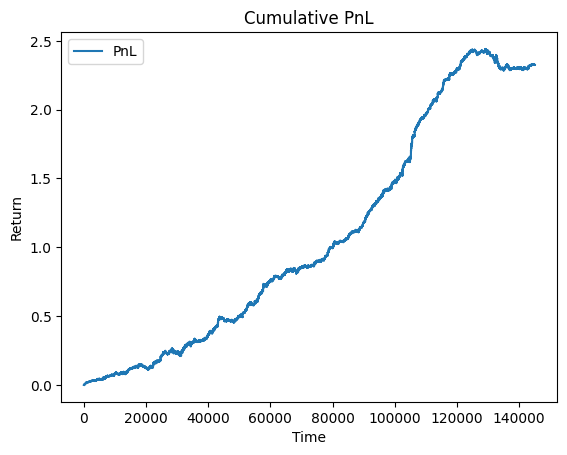

Epoch 5: Loss = 0.037348728626966476
Sharpe Ratio for the epoch: 2.1033
Average Weights:



,Weight
Cash,8.240114e-01
MPWR,1.493597e-01
MTD,2.411074e-02
FICO,2.064014e-03
BKNG,4.542067e-04
...,...
MO,1.252139e-14
BBY,1.228508e-14
MCD,1.079619e-14
ZBH,1.002978e-14


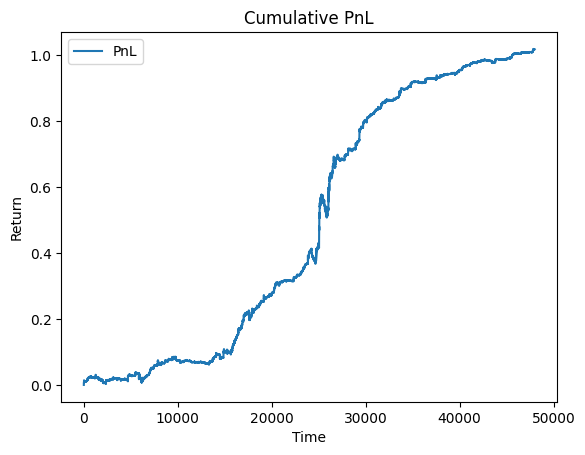

  4%|▍         | 9/200 [07:49<2:44:13, 51.59s/it]

Sharpe Ratio for the epoch: 1.4193
Average Weights:



,Weight
Cash,5.595774e-01
MPWR,4.208786e-01
MTD,1.857200e-02
FICO,8.153912e-04
BKNG,1.567558e-04
...,...
MO,1.709538e-14
BBY,1.684699e-14
MCD,1.478124e-14
ZBH,1.371715e-14


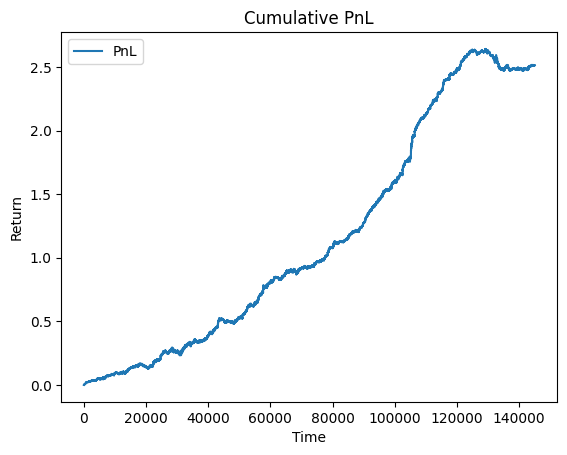

Epoch 10: Loss = 0.06987340748310089
Sharpe Ratio for the epoch: 2.3211
Average Weights:



,Weight
Cash,8.133988e-01
MPWR,1.613702e-01
MTD,2.448551e-02
FICO,6.161239e-04
BKNG,1.294487e-04
...,...
MO,1.094306e-14
BBY,1.073676e-14
MCD,9.437964e-15
ZBH,8.768919e-15


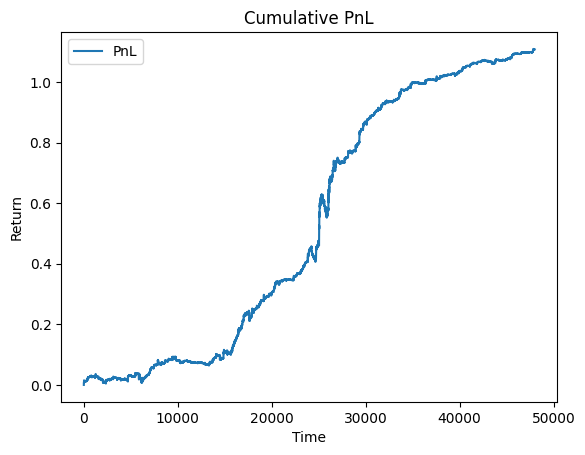

  7%|▋         | 14/200 [12:07<2:39:15, 51.37s/it]

Sharpe Ratio for the epoch: 1.5182
Average Weights:



,Weight
Cash,5.449700e-01
MPWR,4.409288e-01
MTD,1.374893e-02
FICO,2.952140e-04
BKNG,5.714970e-05
...,...
MO,1.511786e-14
BBY,1.489888e-14
MCD,1.307501e-14
ZBH,1.213492e-14


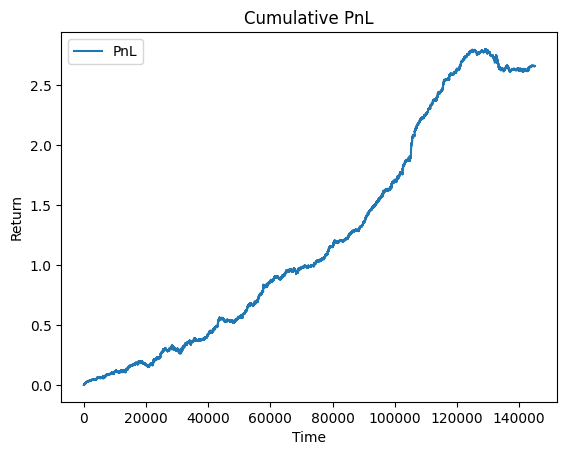

Epoch 15: Loss = 0.09183256328105927
Sharpe Ratio for the epoch: 2.6817
Average Weights:



,Weight
Cash,7.840163e-01
MPWR,1.926912e-01
MTD,2.298440e-02
FICO,2.562109e-04
BKNG,5.186090e-05
...,...
MO,1.072591e-14
BBY,1.052563e-14
MCD,9.253936e-15
ZBH,8.598386e-15


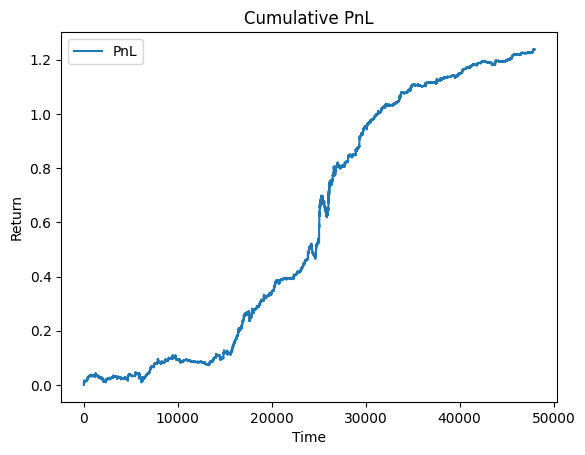

 10%|▉         | 19/200 [16:50<2:52:15, 57.10s/it]

Sharpe Ratio for the epoch: 1.5863
Average Weights:



,Weight
Cash,5.225903e-01
MPWR,4.671763e-01
MTD,1.008252e-02
FICO,1.260203e-04
BKNG,2.494403e-05
...,...
MO,1.381251e-14
BBY,1.361318e-14
MCD,1.194886e-14
ZBH,1.109110e-14


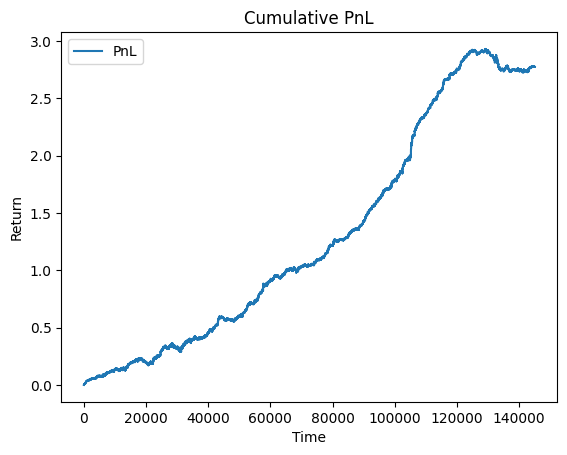

Epoch 20: Loss = 0.0884491503238678
Sharpe Ratio for the epoch: 3.1327
Average Weights:



,Weight
Cash,7.414622e-01
MPWR,2.374278e-01
MTD,2.096312e-02
FICO,1.221621e-04
BKNG,2.472105e-05
...,...
MO,1.091362e-14
BBY,1.071263e-14
MCD,9.419142e-15
ZBH,8.752350e-15


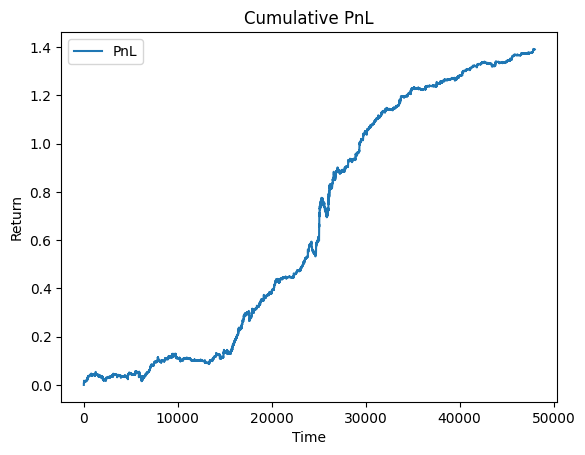

 12%|█▏        | 24/200 [21:16<2:36:52, 53.48s/it]

Sharpe Ratio for the epoch: 1.6440
Average Weights:



,Weight
Cash,5.029261e-01
MPWR,4.892365e-01
MTD,7.764996e-03
FICO,6.003882e-05
BKNG,1.228921e-05
...,...
MO,1.285941e-14
BBY,1.267461e-14
MCD,1.112699e-14
ZBH,1.032949e-14


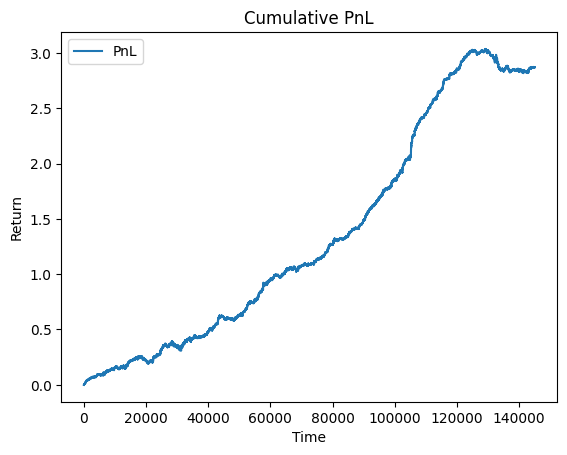

Epoch 25: Loss = 0.07049164921045303
Sharpe Ratio for the epoch: 3.5202
Average Weights:



,Weight
Cash,7.010458e-01
MPWR,2.797582e-01
MTD,1.912048e-02
FICO,6.259512e-05
BKNG,1.294671e-05
...,...
MO,1.097798e-14
BBY,1.077822e-14
MCD,9.477764e-15
ZBH,8.807337e-15


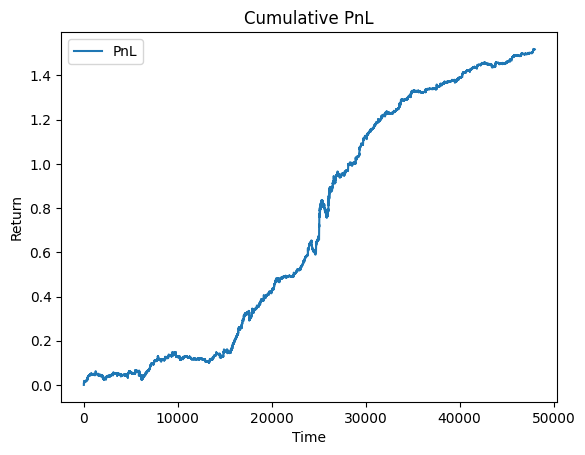

 14%|█▍        | 29/200 [25:27<2:23:31, 50.36s/it]

Sharpe Ratio for the epoch: 1.6998
Average Weights:



,Weight
MPWR,5.023521e-01
Cash,4.912204e-01
MTD,6.389676e-03
FICO,3.126464e-05
BKNG,6.647307e-06
...,...
MO,1.216042e-14
BBY,1.198648e-14
MCD,1.052481e-14
ZBH,9.771528e-15


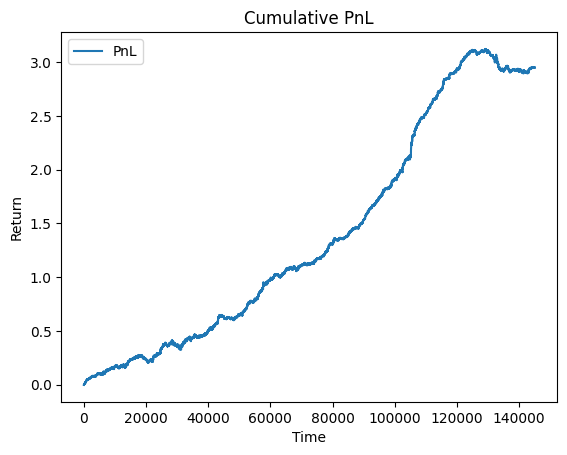

Epoch 30: Loss = 0.056593041867017746
Sharpe Ratio for the epoch: 3.7807
Average Weights:



,Weight
Cash,6.725025e-01
MPWR,3.095852e-01
MTD,1.787126e-02
FICO,3.390059e-05
BKNG,7.243222e-06
...,...
MO,1.084132e-14
BBY,1.064578e-14
MCD,9.362568e-15
ZBH,8.700906e-15


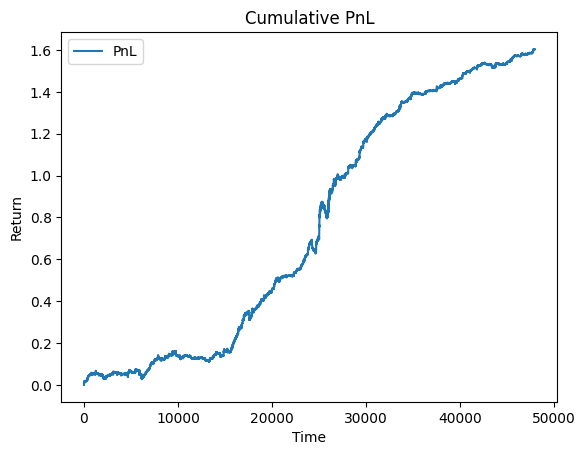

 17%|█▋        | 34/200 [29:42<2:22:18, 51.44s/it]

Sharpe Ratio for the epoch: 1.7510
Average Weights:



,Weight
MPWR,5.108443e-01
Cash,4.836490e-01
MTD,5.485512e-03
FICO,1.733281e-05
BKNG,3.841525e-06
...,...
MO,1.161298e-14
BBY,1.144765e-14
MCD,1.005356e-14
ZBH,9.334929e-15


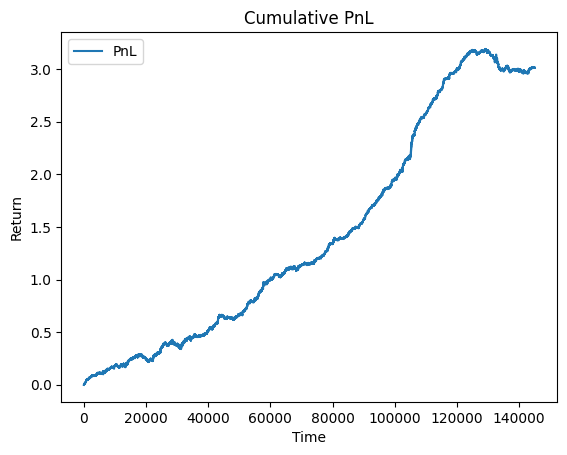

Epoch 35: Loss = 0.046017810702323914
Sharpe Ratio for the epoch: 3.9684
Average Weights:



,Weight
Cash,6.513472e-01
MPWR,3.314977e-01
MTD,1.713173e-02
FICO,1.922731e-05
BKNG,4.269781e-06
...,...
MO,1.063491e-14
BBY,1.044445e-14
MCD,9.186933e-15
ZBH,8.538285e-15


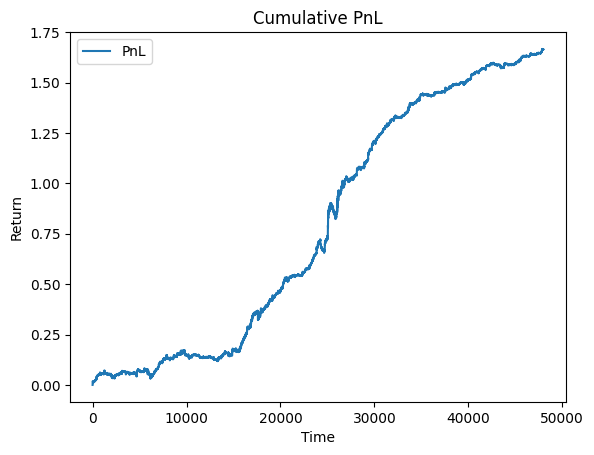

 20%|█▉        | 39/200 [34:12<2:23:14, 53.38s/it]

Sharpe Ratio for the epoch: 1.7993
Average Weights:



,Weight
MPWR,5.154333e-01
Cash,4.796985e-01
MTD,4.855843e-03
FICO,1.004218e-05
BKNG,2.324389e-06
...,...
MO,1.115866e-14
BBY,1.100072e-14
MCD,9.662855e-15
ZBH,8.972978e-15


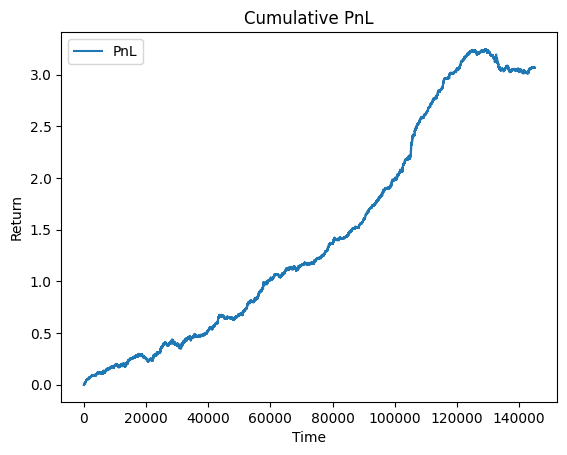

Epoch 40: Loss = 0.045113202184438705
Sharpe Ratio for the epoch: 4.0708
Average Weights:



,Weight
Cash,6.417882e-01
MPWR,3.414911e-01
MTD,1.670684e-02
FICO,1.127878e-05
BKNG,2.611376e-06
...,...
MO,1.034719e-14
BBY,1.016309e-14
MCD,8.940991e-15
ZBH,8.310405e-15


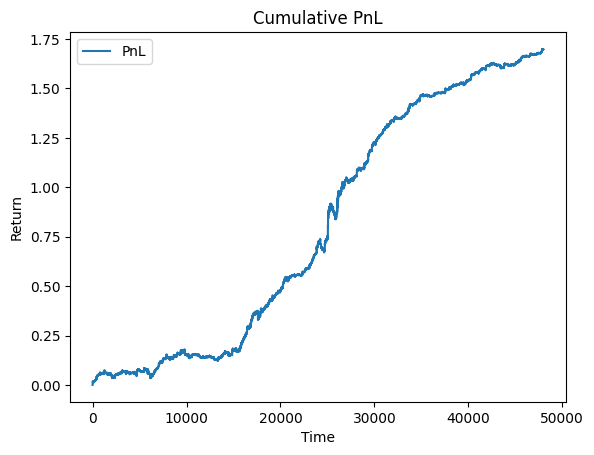

 22%|██▏       | 44/200 [38:34<2:14:16, 51.65s/it]

Sharpe Ratio for the epoch: 1.8439
Average Weights:



,Weight
MPWR,5.178078e-01
Cash,4.777877e-01
MTD,4.396997e-03
FICO,6.009039e-06
BKNG,1.451594e-06
...,...
MO,1.076607e-14
BBY,1.061470e-14
MCD,9.325677e-15
ZBH,8.660591e-15


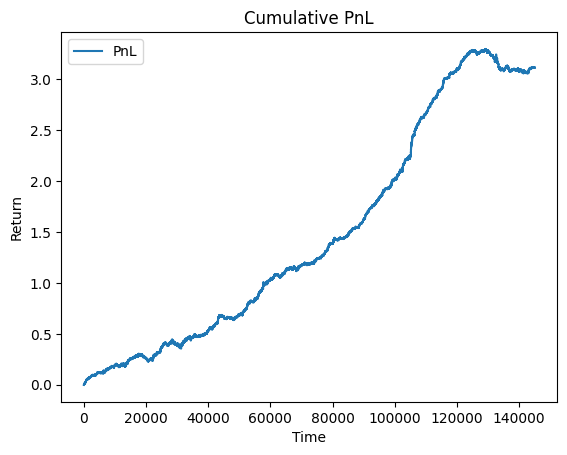

Epoch 45: Loss = 0.05012994632124901
Sharpe Ratio for the epoch: 4.1227
Average Weights:



,Weight
Cash,6.391762e-01
MPWR,3.443460e-01
MTD,1.646947e-02
FICO,6.800761e-06
BKNG,1.641351e-06
...,...
MO,1.003827e-14
BBY,9.860873e-15
MCD,8.676817e-15
ZBH,8.065549e-15


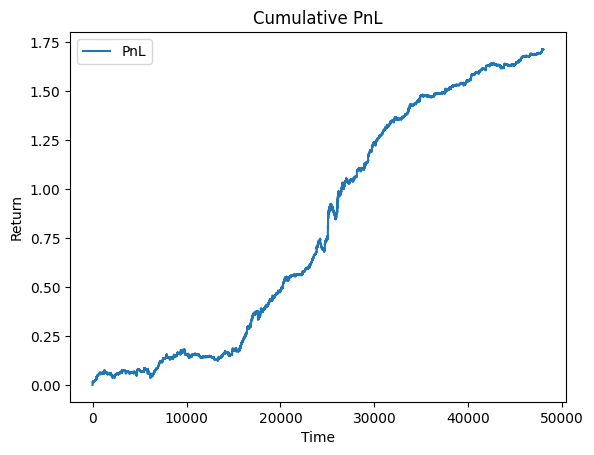

 24%|██▍       | 49/200 [43:03<2:15:21, 53.78s/it]

Sharpe Ratio for the epoch: 1.8848
Average Weights:



,Weight
MPWR,5.185479e-01
Cash,4.773758e-01
MTD,4.071744e-03
FICO,3.683929e-06
BKNG,9.269679e-07
...,...
MO,1.041918e-14
BBY,1.027368e-14
MCD,9.027931e-15
ZBH,8.384894e-15


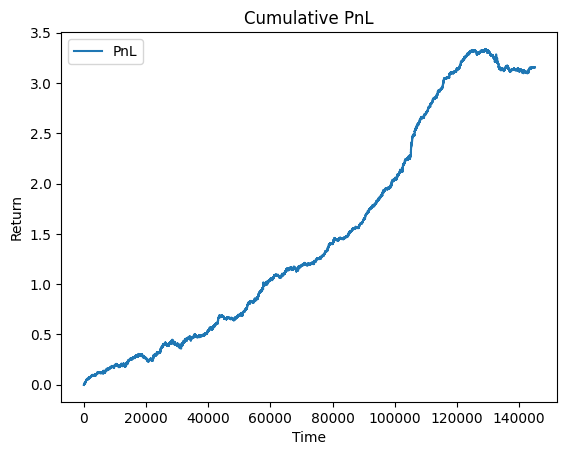

Epoch 50: Loss = 0.06219814717769623
Sharpe Ratio for the epoch: 4.1286
Average Weights:



,Weight
Cash,6.424875e-01
MPWR,3.411236e-01
MTD,1.638365e-02
FICO,4.189555e-06
BKNG,1.052247e-06
...,...
MO,9.720060e-15
BBY,9.549359e-15
MCD,8.404423e-15
ZBH,7.813200e-15


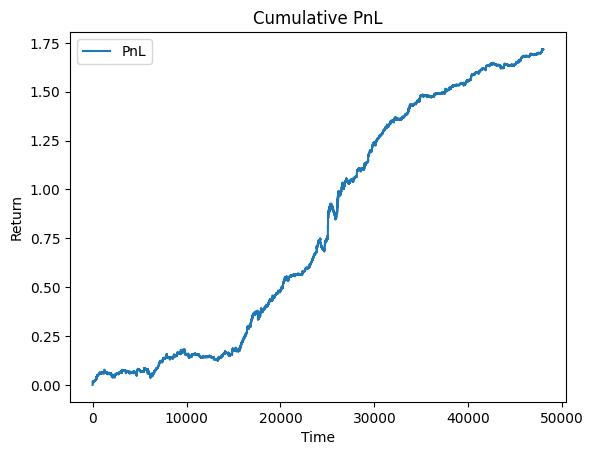

 27%|██▋       | 54/200 [47:33<2:12:10, 54.32s/it]

Sharpe Ratio for the epoch: 1.9238
Average Weights:



,Weight
MPWR,5.184328e-01
Cash,4.777323e-01
MTD,3.831949e-03
FICO,2.301067e-06
BKNG,6.014462e-07
...,...
MO,1.010727e-14
BBY,9.967063e-15
MCD,8.760285e-15
ZBH,8.137205e-15


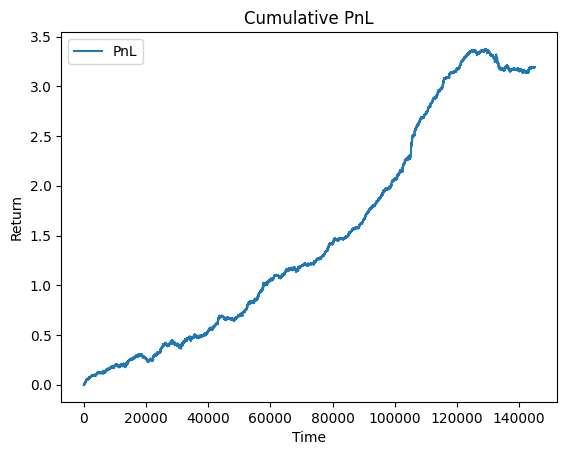

Epoch 55: Loss = 0.08286917954683304
Sharpe Ratio for the epoch: 4.0929
Average Weights:



,Weight
Cash,6.505783e-01
MPWR,3.329925e-01
MTD,1.642588e-02
FICO,2.625477e-06
BKNG,6.843819e-07
...,...
MO,9.398461e-15
BBY,9.234405e-15
MCD,8.128895e-15
ZBH,7.558038e-15


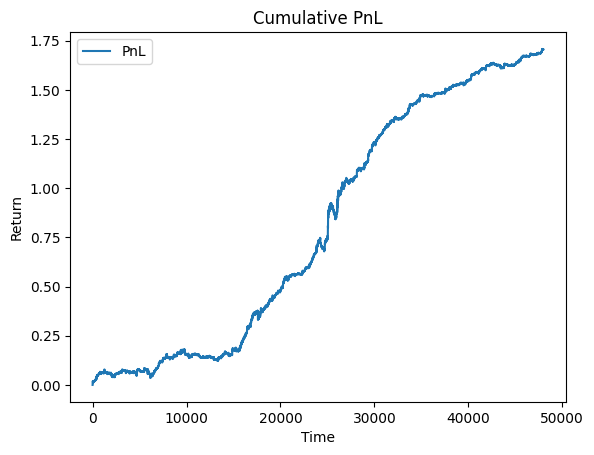

 30%|██▉       | 59/200 [51:52<2:02:07, 51.97s/it]

Sharpe Ratio for the epoch: 1.9603
Average Weights:



,Weight
MPWR,5.172466e-01
Cash,4.790898e-01
MTD,3.661690e-03
FICO,1.459951e-06
BKNG,3.949188e-07
...,...
MO,9.826443e-15
BBY,9.691009e-15
MCD,8.519409e-15
ZBH,7.914377e-15


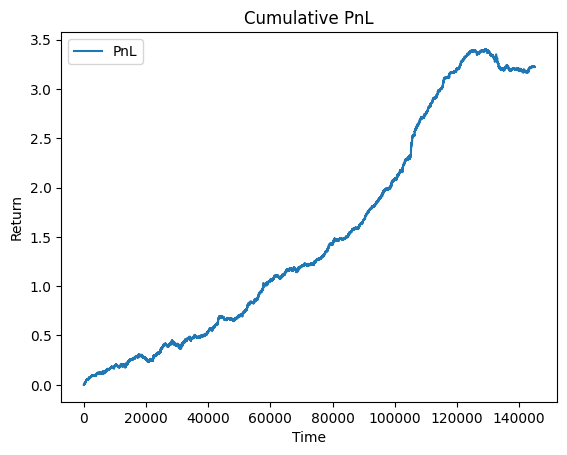

Epoch 60: Loss = 0.11251392215490341
Sharpe Ratio for the epoch: 4.0242
Average Weights:



,Weight
Cash,6.618429e-01
MPWR,3.216368e-01
MTD,1.651810e-02
FICO,1.667616e-06
BKNG,4.495704e-07
...,...
MO,9.074812e-15
BBY,8.917256e-15
MCD,7.851396e-15
ZBH,7.301033e-15


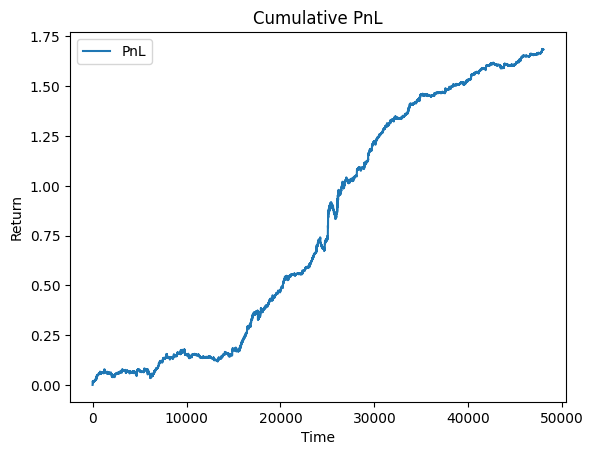

 32%|███▏      | 64/200 [56:07<1:54:25, 50.48s/it]

Sharpe Ratio for the epoch: 1.9950
Average Weights:



,Weight
MPWR,5.151538e-01
Cash,4.813059e-01
MTD,3.539286e-03
FICO,9.383400e-07
BKNG,2.616777e-07
...,...
MO,9.570242e-15
BBY,9.439145e-15
MCD,8.299746e-15
ZBH,7.711224e-15


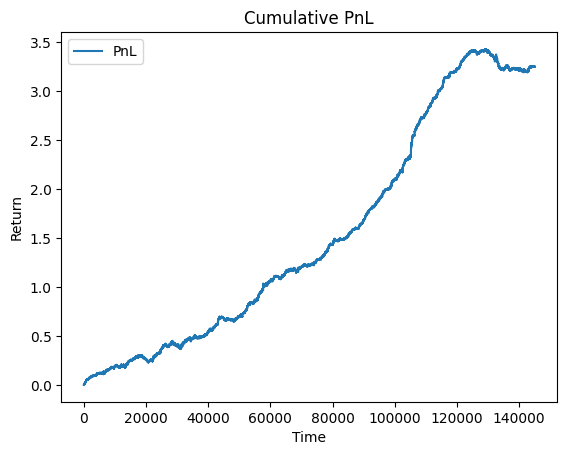

Epoch 65: Loss = 0.15178462862968445
Sharpe Ratio for the epoch: 3.9281
Average Weights:



,Weight
Cash,6.752456e-01
MPWR,3.081016e-01
MTD,1.665145e-02
FICO,1.070810e-06
BKNG,2.974847e-07
...,...
MO,8.750345e-15
BBY,8.599128e-15
MCD,7.572973e-15
ZBH,7.043167e-15


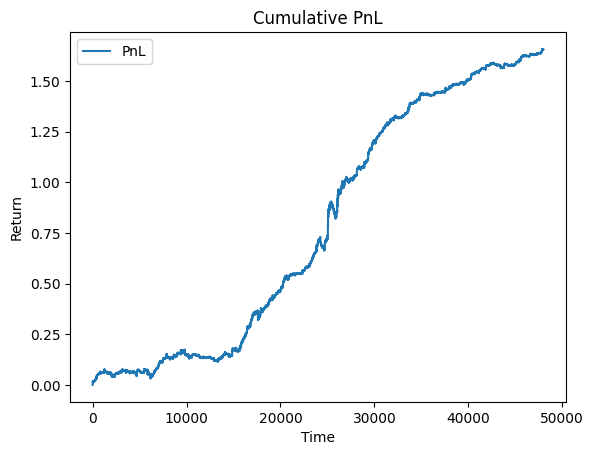

 34%|███▍      | 69/200 [1:00:20<1:49:55, 50.35s/it]

Sharpe Ratio for the epoch: 2.0284
Average Weights:



,Weight
MPWR,5.119708e-01
Cash,4.845717e-01
MTD,3.456691e-03
FICO,6.101143e-07
BKNG,1.747220e-07
...,...
MO,9.337715e-15
BBY,9.210569e-15
MCD,8.100511e-15
ZBH,7.527017e-15


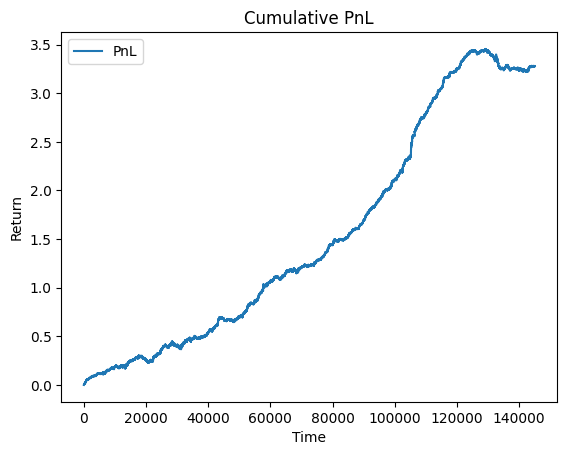

Epoch 70: Loss = 0.20078977942466736
Sharpe Ratio for the epoch: 3.8094
Average Weights:



,Weight
Cash,6.900370e-01
MPWR,2.931320e-01
MTD,1.683011e-02
FICO,6.940049e-07
BKNG,1.979676e-07
...,...
MO,8.428046e-15
BBY,8.282936e-15
MCD,7.296222e-15
ZBH,6.786804e-15


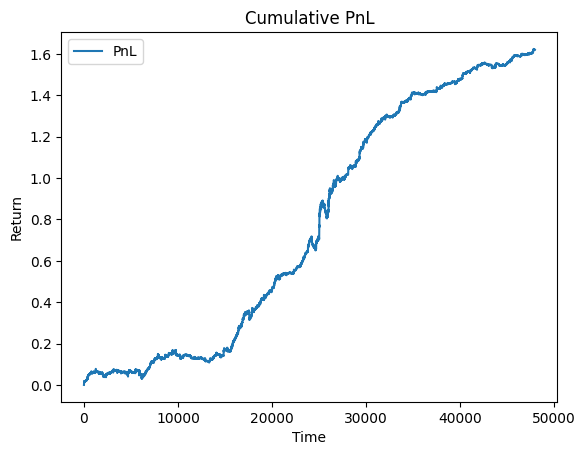

 37%|███▋      | 74/200 [1:04:41<1:47:07, 51.01s/it]

Sharpe Ratio for the epoch: 2.0620
Average Weights:



,Weight
MPWR,5.070563e-01
Cash,4.895319e-01
MTD,3.411318e-03
FICO,4.013177e-07
BKNG,1.175582e-07
...,...
MO,9.137710e-15
BBY,9.014021e-15
MCD,7.929362e-15
ZBH,7.368943e-15


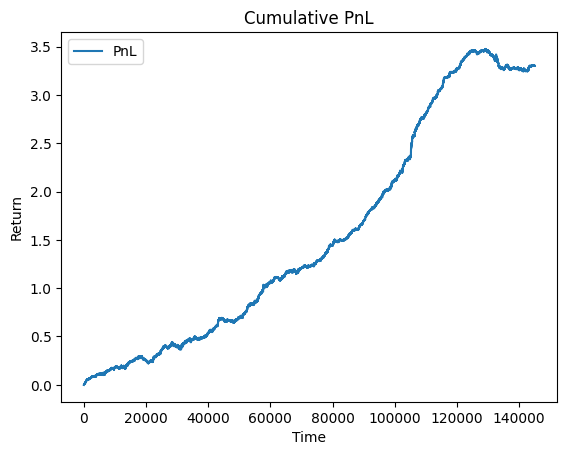

Epoch 75: Loss = 0.257389098405838
Sharpe Ratio for the epoch: 3.6785
Average Weights:



,Weight
Cash,7.052598e-01
MPWR,2.777810e-01
MTD,1.695858e-02
FICO,4.529855e-07
BKNG,1.322317e-07
...,...
MO,8.104307e-15
BBY,7.965133e-15
MCD,7.017965e-15
ZBH,6.529050e-15


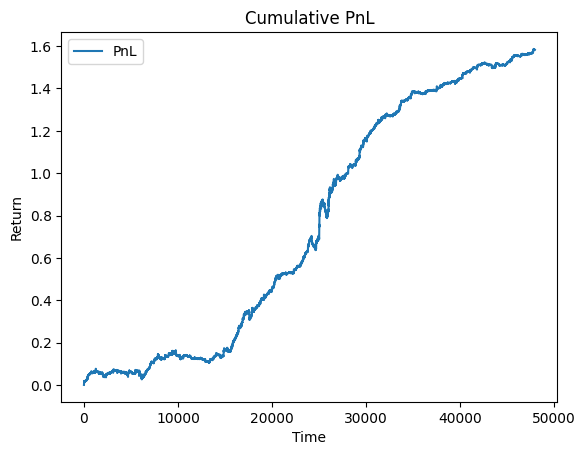

 40%|███▉      | 79/200 [1:09:05<1:48:06, 53.61s/it]

Sharpe Ratio for the epoch: 2.0956
Average Weights:



,Weight
MPWR,5.004135e-01
Cash,4.961832e-01
MTD,3.402906e-03
FICO,2.665784e-07
BKNG,7.961112e-08
...,...
MO,8.965184e-15
BBY,8.844552e-15
MCD,7.782002e-15
ZBH,7.232981e-15


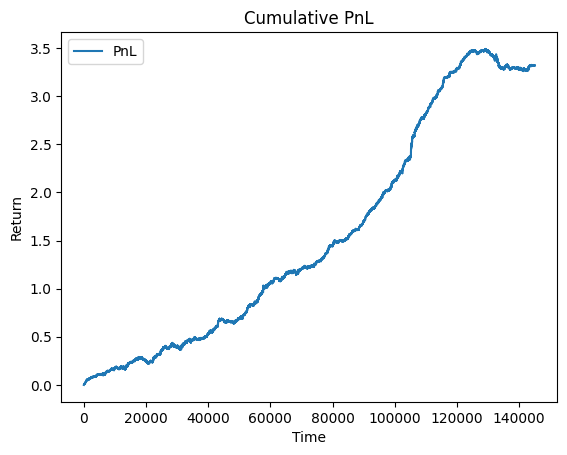

Epoch 80: Loss = 0.3163500130176544
Sharpe Ratio for the epoch: 3.5484
Average Weights:



,Weight
Cash,7.195261e-01
MPWR,2.633906e-01
MTD,1.708298e-02
FICO,2.976380e-07
BKNG,8.865331e-08
...,...
MO,7.796295e-15
BBY,7.662634e-15
MCD,6.753134e-15
ZBH,6.283732e-15


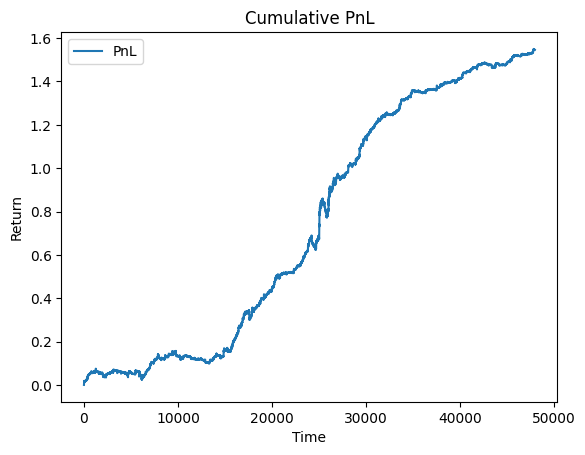

 42%|████▏     | 84/200 [1:13:30<1:40:25, 51.95s/it]

Sharpe Ratio for the epoch: 2.1290
Average Weights:



,Weight
Cash,5.042839e-01
MPWR,4.922847e-01
MTD,3.430977e-03
FICO,1.786919e-07
BKNG,5.421911e-08
...,...
MO,8.816516e-15
BBY,8.698658e-15
MCD,7.655339e-15
ZBH,7.116266e-15


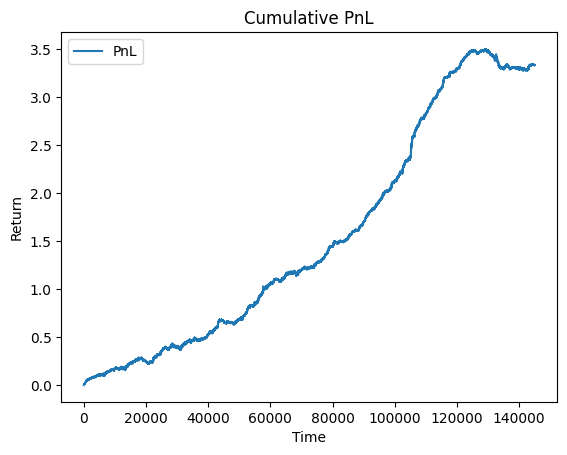

Epoch 85: Loss = 0.37113457918167114
Sharpe Ratio for the epoch: 3.4314
Average Weights:



,Weight
Cash,7.317345e-01
MPWR,2.510295e-01
MTD,1.723580e-02
FICO,1.970081e-07
BKNG,5.968285e-08
...,...
MO,7.518734e-15
BBY,7.390004e-15
MCD,6.514532e-15
ZBH,6.062748e-15


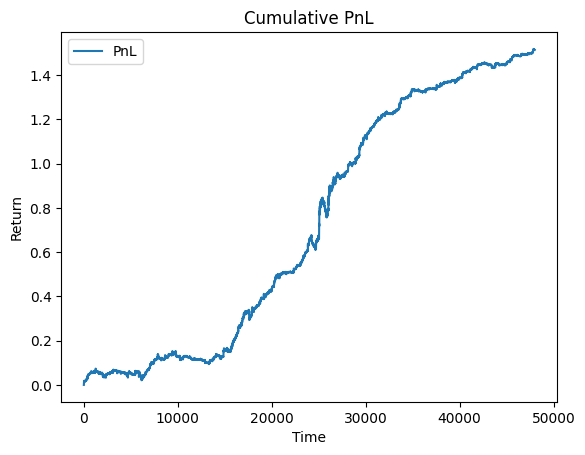

 44%|████▍     | 89/200 [1:17:37<1:31:33, 49.49s/it]

Sharpe Ratio for the epoch: 2.1614
Average Weights:



,Weight
Cash,5.129684e-01
MPWR,4.835442e-01
MTD,3.487216e-03
FICO,1.206260e-07
BKNG,3.706711e-08
...,...
MO,8.683196e-15
BBY,8.567883e-15
MCD,7.541936e-15
ZBH,7.011834e-15


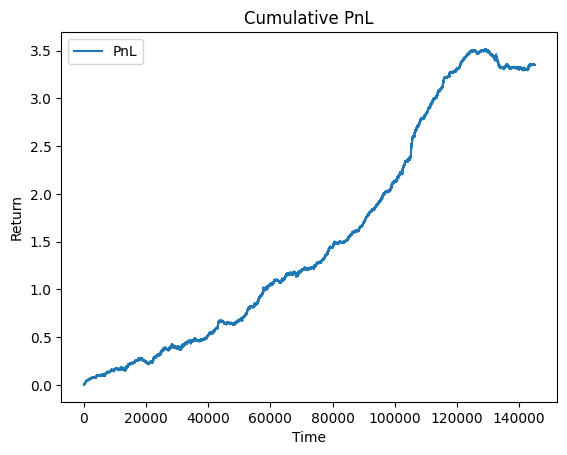

Epoch 90: Loss = 0.4169867932796478
Sharpe Ratio for the epoch: 3.3375
Average Weights:



,Weight
Cash,7.410616e-01
MPWR,2.415060e-01
MTD,1.743228e-02
FICO,1.313964e-07
BKNG,4.035347e-08
...,...
MO,7.283324e-15
BBY,7.158777e-15
MCD,6.312308e-15
ZBH,5.875502e-15


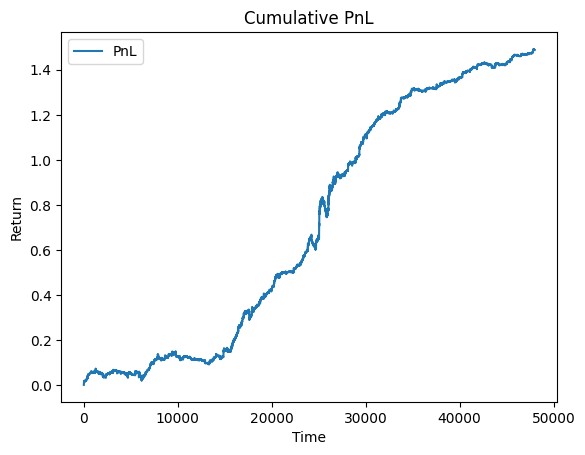

 47%|████▋     | 94/200 [1:21:38<1:25:28, 48.38s/it]

Sharpe Ratio for the epoch: 2.1916
Average Weights:



,Weight
Cash,5.210062e-01
MPWR,4.754377e-01
MTD,3.556115e-03
FICO,8.180688e-08
BKNG,2.539149e-08
...,...
MO,8.557005e-15
BBY,8.444124e-15
MCD,7.434716e-15
ZBH,6.913092e-15


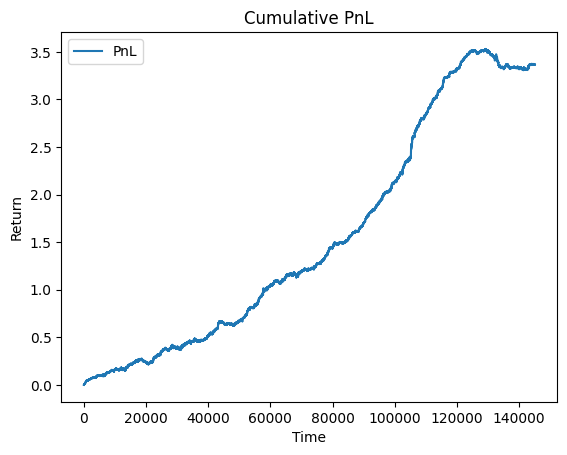

Epoch 95: Loss = 0.4511180520057678
Sharpe Ratio for the epoch: 3.2699
Average Weights:



,Weight
Cash,7.473336e-01
MPWR,2.349867e-01
MTD,1.767950e-02
FICO,8.828791e-08
BKNG,2.740721e-08
...,...
MO,7.095769e-15
BBY,6.974657e-15
MCD,6.151536e-15
ZBH,5.726723e-15


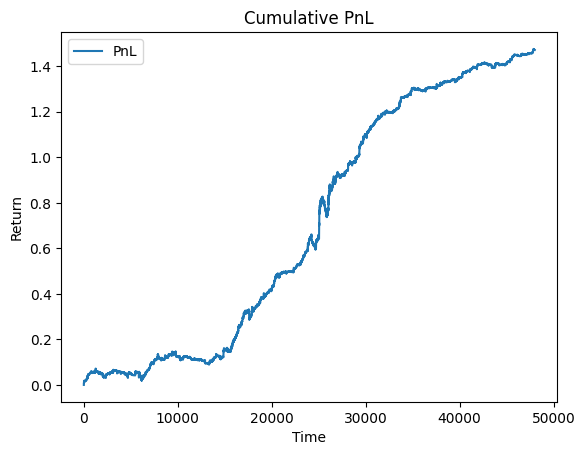

 50%|████▉     | 99/200 [1:25:40<1:21:22, 48.34s/it]

Sharpe Ratio for the epoch: 2.2208
Average Weights:



,Weight
Cash,5.281692e-01
MPWR,4.682084e-01
MTD,3.622397e-03
FICO,5.562243e-08
BKNG,1.740363e-08
...,...
MO,8.431588e-15
BBY,8.321089e-15
MCD,7.328094e-15
ZBH,6.814853e-15


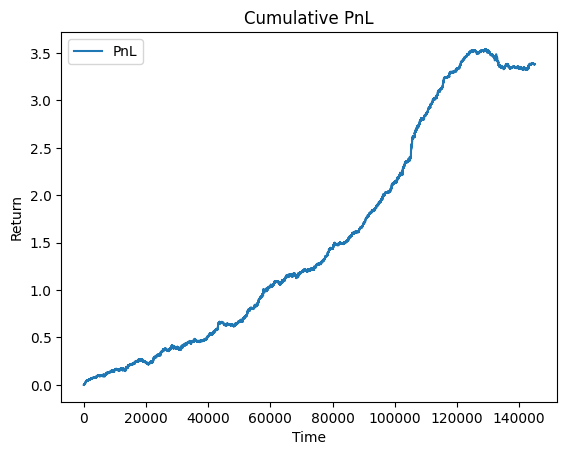

Epoch 100: Loss = 0.4823876917362213
Sharpe Ratio for the epoch: 3.2050
Average Weights:



,Weight
Cash,7.529473e-01
MPWR,2.290854e-01
MTD,1.796714e-02
FICO,5.958589e-08
BKNG,1.865727e-08
...,...
MO,6.926185e-15
BBY,6.808191e-15
MCD,6.006253e-15
ZBH,5.592298e-15


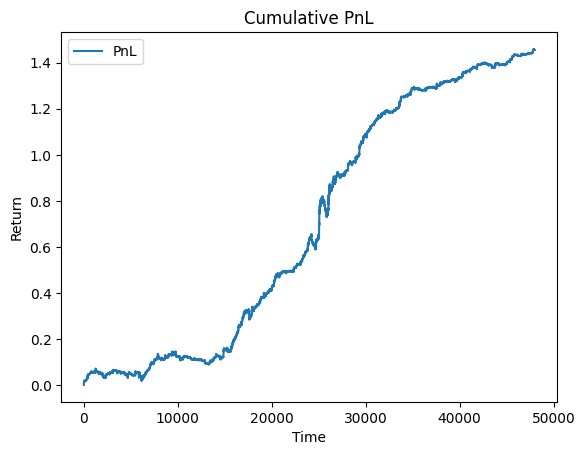

 52%|█████▏    | 104/200 [1:29:41<1:17:11, 48.24s/it]

Sharpe Ratio for the epoch: 75.2763
Average Weights:



,Weight
MPWR,6.148064e-01
Cash,3.851196e-01
MTD,7.397476e-05
FICO,5.099845e-09
BKNG,1.657614e-09
...,...
MO,5.275133e-15
BBY,5.203987e-15
MCD,4.593512e-15
ZBH,4.278617e-15


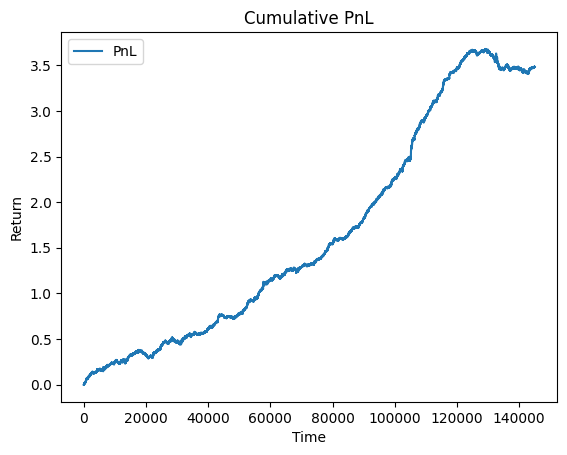

Epoch 105: Loss = -14.883915901184082
Sharpe Ratio for the epoch: 141.3721
Average Weights:



,Weight
MPWR,5.423661e-01
Cash,4.538152e-01
MTD,3.818555e-03
FICO,5.791283e-09
BKNG,1.825293e-09
...,...
ALB,5.348457e-15
BBY,5.258265e-15
MCD,4.650405e-15
ZBH,4.335986e-15


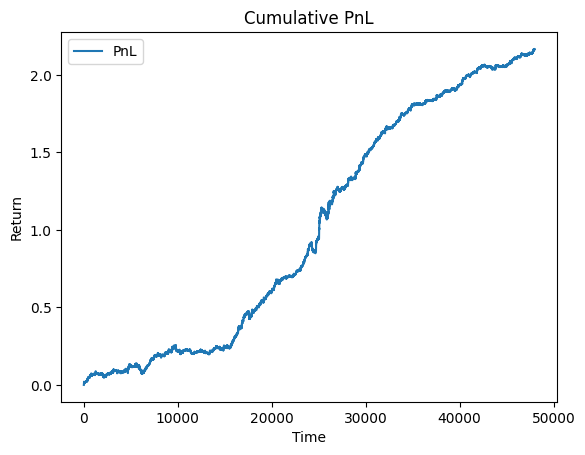

 55%|█████▍    | 109/200 [1:33:43<1:13:19, 48.35s/it]

Sharpe Ratio for the epoch: 76.0708
Average Weights:



,Weight
MPWR,6.109205e-01
Cash,3.890126e-01
MTD,6.669261e-05
FICO,2.124211e-09
BKNG,7.037933e-10
...,...
MO,5.093435e-15
BBY,5.026559e-15
MCD,4.446526e-15
ZBH,4.148722e-15


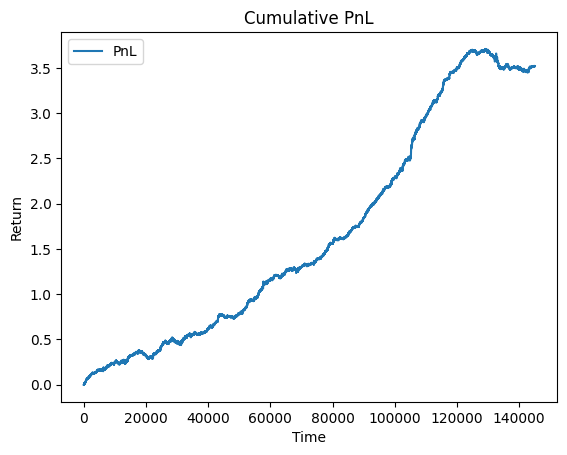

Epoch 110: Loss = -5.4598541259765625
Sharpe Ratio for the epoch: 132.9638
Average Weights:



,Weight
Cash,5.431550e-01
MPWR,4.531836e-01
MTD,3.661435e-03
FICO,2.770014e-09
BKNG,8.869285e-10
...,...
ALB,5.308594e-15
BBY,5.228025e-15
MCD,4.633579e-15
ZBH,4.328285e-15


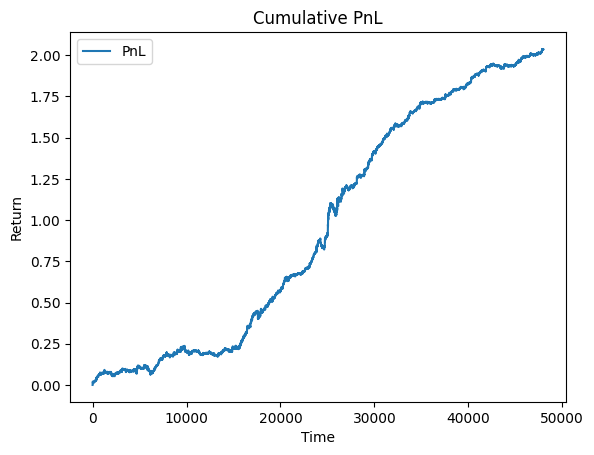

 57%|█████▋    | 114/200 [1:37:45<1:09:09, 48.25s/it]

Sharpe Ratio for the epoch: 76.4998
Average Weights:



,Weight
MPWR,6.087478e-01
Cash,3.911895e-01
MTD,6.265110e-05
FICO,1.155688e-09
BKNG,3.855671e-10
...,...
MO,4.938454e-15
BBY,4.875308e-15
MCD,4.321825e-15
ZBH,4.038955e-15


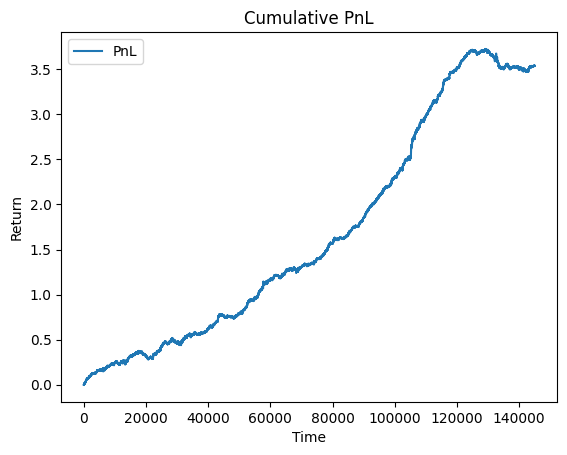

Epoch 115: Loss = -3.7805871963500977
Sharpe Ratio for the epoch: 130.2314
Average Weights:



,Weight
Cash,5.626066e-01
MPWR,4.335047e-01
MTD,3.888779e-03
FICO,1.545266e-09
BKNG,4.966552e-10
...,...
ALB,5.161607e-15
BBY,5.092500e-15
MCD,4.522891e-15
ZBH,4.231891e-15


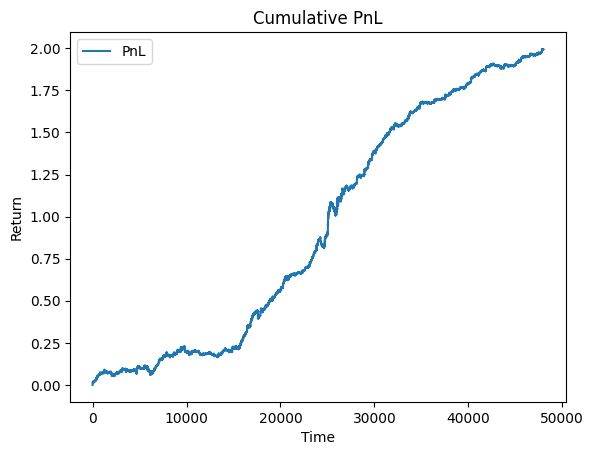

 60%|█████▉    | 119/200 [1:41:46<1:05:05, 48.22s/it]

Sharpe Ratio for the epoch: 76.8756
Average Weights:



,Weight
MPWR,6.075442e-01
Cash,3.923923e-01
MTD,6.333714e-05
FICO,6.972244e-10
BKNG,2.334420e-10
...,...
MO,4.807861e-15
BBY,4.748024e-15
MCD,4.217590e-15
ZBH,3.947752e-15


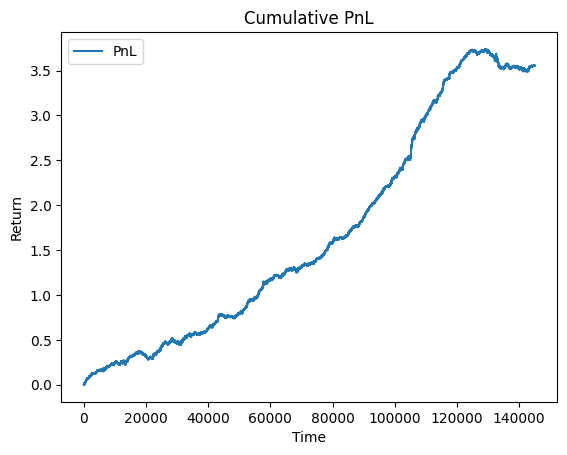

Epoch 120: Loss = -2.9948503971099854
Sharpe Ratio for the epoch: 129.3237
Average Weights:



,Weight
Cash,5.743123e-01
MPWR,4.226040e-01
MTD,3.083732e-03
FICO,9.605406e-10
BKNG,3.129240e-10
...,...
ALB,4.977143e-15
BBY,4.919606e-15
MCD,4.378615e-15
ZBH,4.103615e-15


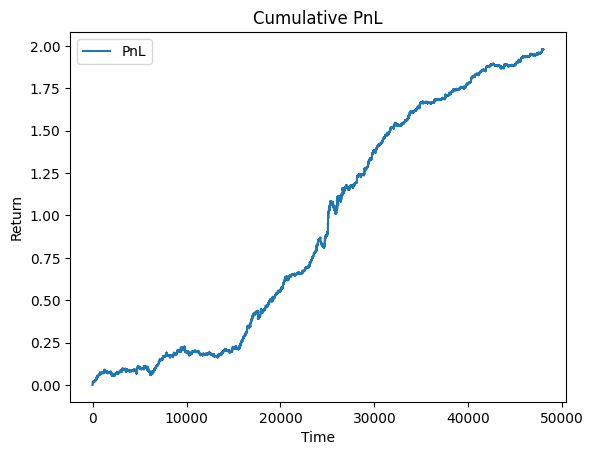

 62%|██████▏   | 124/200 [1:46:21<1:09:01, 54.50s/it]

Sharpe Ratio for the epoch: 77.2041
Average Weights:



,Weight
MPWR,6.074863e-01
Cash,3.924576e-01
MTD,5.600933e-05
FICO,4.401361e-10
BKNG,1.484648e-10
...,...
ALB,4.655388e-15
BBY,4.603241e-15
MCD,4.097048e-15
ZBH,3.840807e-15


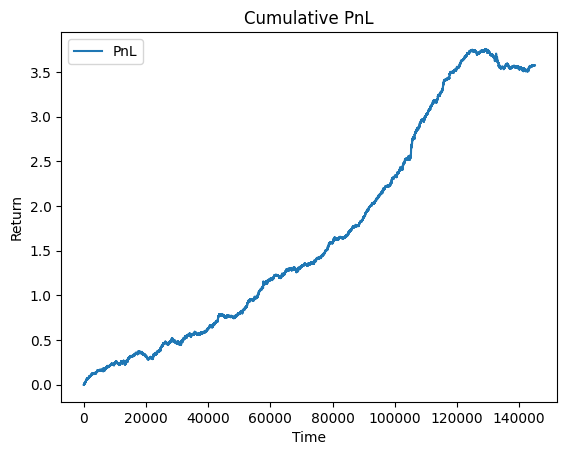

Epoch 125: Loss = -4.012559413909912
Sharpe Ratio for the epoch: 129.3954
Average Weights:



,Weight
Cash,5.698892e-01
MPWR,4.262065e-01
MTD,3.904181e-03
FICO,5.984712e-10
BKNG,1.941161e-10
...,...
ALB,4.881292e-15
BBY,4.833028e-15
MCD,4.309641e-15
ZBH,4.044949e-15


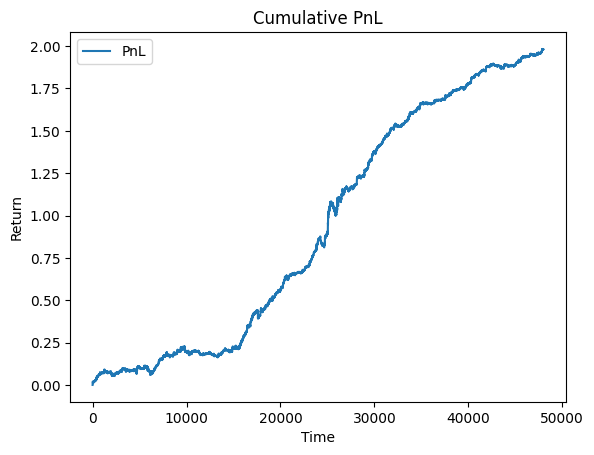

 64%|██████▍   | 129/200 [1:50:52<1:05:04, 54.99s/it]

Sharpe Ratio for the epoch: 77.5185
Average Weights:



,Weight
MPWR,6.070471e-01
Cash,3.928928e-01
MTD,6.027922e-05
FICO,2.875110e-10
BKNG,9.729407e-11
...,...
ALB,4.540595e-15
BBY,4.497438e-15
MCD,4.010478e-15
ZBH,3.765249e-15


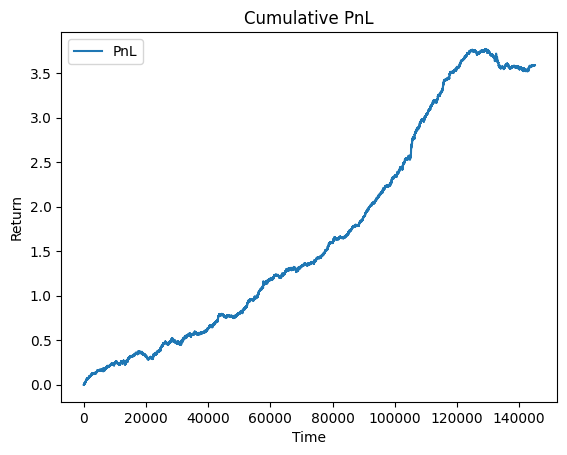

Epoch 130: Loss = -3.7329699993133545
Sharpe Ratio for the epoch: 129.3092
Average Weights:



,Weight
Cash,5.762373e-01
MPWR,4.206532e-01
MTD,3.109622e-03
FICO,3.987189e-10
BKNG,1.309325e-10
...,...
ALB,4.711987e-15
BBY,4.673619e-15
MCD,4.175739e-15
ZBH,3.925322e-15


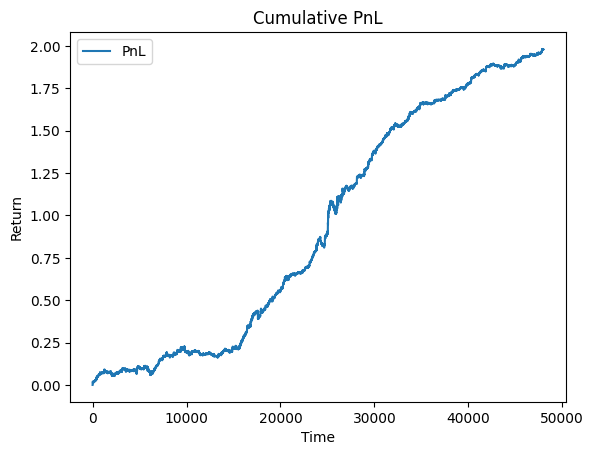

 67%|██████▋   | 134/200 [1:55:24<59:37, 54.20s/it]  

Sharpe Ratio for the epoch: 77.7985
Average Weights:



,Weight
MPWR,6.071001e-01
Cash,3.928457e-01
MTD,5.418514e-05
FICO,1.898192e-10
BKNG,6.473102e-11
...,...
ALB,4.396779e-15
BBY,4.362227e-15
MCD,3.897034e-15
ZBH,3.664074e-15


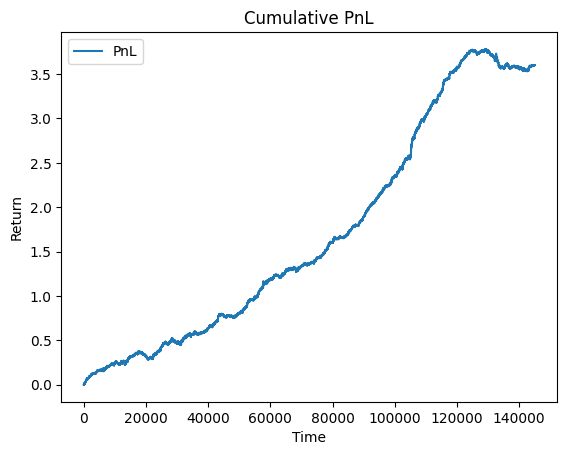

Epoch 135: Loss = -4.811611652374268
Sharpe Ratio for the epoch: 129.9416
Average Weights:



,Weight
Cash,5.705236e-01
MPWR,4.258509e-01
MTD,3.625483e-03
FICO,2.602306e-10
BKNG,8.538718e-11
...,...
ALB,4.608105e-15
BBY,4.578012e-15
MCD,4.097517e-15
ZBH,3.857245e-15


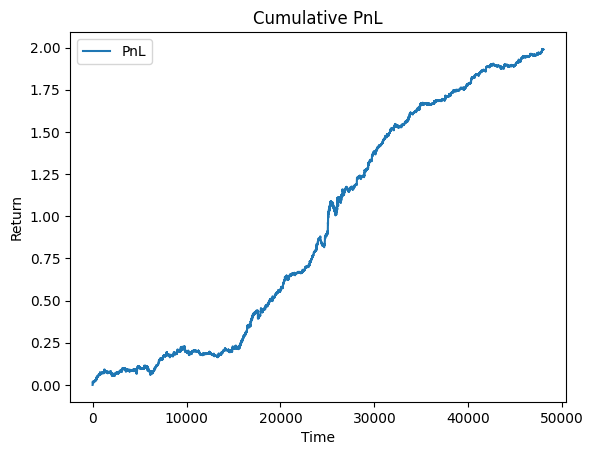

 70%|██████▉   | 139/200 [2:00:00<54:58, 54.07s/it]  

Sharpe Ratio for the epoch: 78.0791
Average Weights:



,Weight
MPWR,6.070765e-01
Cash,3.928677e-01
MTD,5.600356e-05
FICO,1.273894e-10
BKNG,4.364207e-11
...,...
ALB,4.285001e-15
BBY,4.258225e-15
MCD,3.810821e-15
ZBH,3.588079e-15


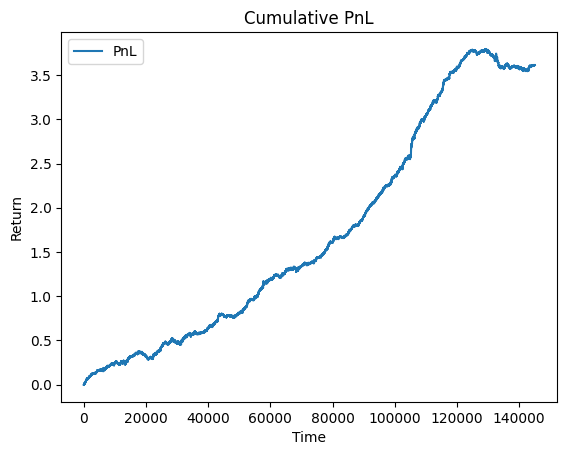

Epoch 140: Loss = -5.058087348937988
Sharpe Ratio for the epoch: 130.3149
Average Weights:



,Weight
Cash,5.717620e-01
MPWR,4.251392e-01
MTD,3.098823e-03
FICO,1.767841e-10
BKNG,5.864579e-11
...,...
ALB,4.465429e-15
BBY,4.443628e-15
MCD,3.984450e-15
ZBH,3.756235e-15


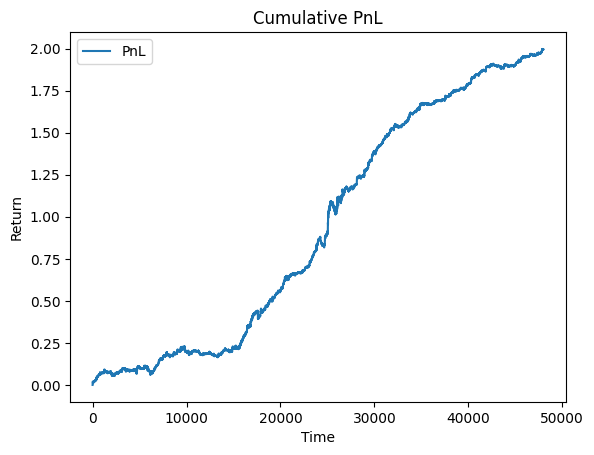

 70%|███████   | 140/200 [2:02:07<52:20, 52.34s/it]


KeyboardInterrupt: 

In [4]:
from copy import deepcopy

loss_fn = StreamingSharpeLoss(
    fee=fee,
    asset_names=pipeline.reader.asset_names + ['Cash'],
)

# from here https://github.com/ChistyakovArtem/share-optim-nn/blob/exps/second_try_2_models/model_iteration_0_epoch_200.pth
m0_path = 'model_iteration_0_epoch_200.pth'

prev_models = []
for i in range(len(prev_models), 10):

    # ad-hoc so far, mb add this to pipeline
    train_cash_left = []
    for common_feats_old, asset_feats, fut_ret, min_prices, market_caps in pipeline.iterate('train'):

        # Перевод в тензоры
        common_feats = torch.tensor(common_feats_old.values, dtype=torch.float32).to(device)       # (T, d_common)
        asset_feats  = torch.tensor(asset_feats,         dtype=torch.float32).to(device)       # (T, n_assets, d_asset)
        fut_ret      = torch.tensor(fut_ret.values,      dtype=torch.float32).to(device)       # (T, n_assets)
        min_prices  = torch.tensor(min_prices.values,   dtype=torch.float32).to(device)       # (T, n_assets)
        market_caps = torch.tensor(market_caps.values,  dtype=torch.float32).to(device)       # (T, n_assets)

        if len(common_feats) != batch_size:
            continue

        cash_left = torch.ones((common_feats.shape[0], 1), dtype=torch.float32, device=device)  # (T, 1)
        for prev_model in prev_models:
            common_feats_tmp = common_feats_old.copy()
            common_feats_tmp['cash_left'] = cash_left.detach().numpy()
            common_feats_tmp = torch.tensor(common_feats_tmp.values, dtype=torch.float32).to(device)
            cash_left *= prev_model(common_feats_tmp, asset_feats)[:, -1:]

        train_cash_left.append(cash_left.detach())
    
    test_cash_left = []
    for common_feats_old, asset_feats, fut_ret, min_prices, market_caps in pipeline.iterate('test'):

        common_feats = torch.tensor(common_feats_old.values, dtype=torch.float32).to(device)
        asset_feats  = torch.tensor(asset_feats,         dtype=torch.float32).to(device)
        fut_ret      = torch.tensor(fut_ret.values,      dtype=torch.float32).to(device)
        min_prices  = torch.tensor(min_prices.values,   dtype=torch.float32).to(device)
        market_caps = torch.tensor(market_caps.values,  dtype=torch.float32).to(device)
        
        if len(common_feats) != batch_size:
            continue

        cash_left = torch.ones((common_feats.shape[0], 1), dtype=torch.float32, device=device)  # (T, 1)
        for prev_model in prev_models:
            common_feats_tmp = common_feats_old.copy()
            common_feats_tmp['cash_left'] = cash_left.detach().numpy()
            common_feats_tmp = torch.tensor(common_feats_tmp.values, dtype=torch.float32).to(device)
            cash_left *= prev_model(common_feats_tmp, asset_feats)[:, -1:]
        test_cash_left.append(cash_left.detach())

    model = SimplePortfolioAllocator(
        cmf_dim=cmf_dim + 1,
        num_assets=num_assets,
    ).to(device)
    model.load_state_dict(torch.load(m0_path, map_location=device))

    optimizer = torch.optim.Adam(model.parameters(), lr=adam_lr)

    for epoch in tqdm(range(num_epochs)):
        if epoch in batch_size_config:
            print(f"Changing batch size to {batch_size_config[epoch]} at epoch {epoch}")
            batch_size = batch_size_config[epoch]
            pipeline = FeaturesPipeline(
                path_to_data,
                padding=padding,
                batch_size=batch_size,
                split_dates=split_dates,
                split_names=split_names
            )

        if epoch == 0:
            loss_fn = StreamingSharpeLoss(
                fee=fee,
                asset_names=pipeline.reader.asset_names + ['Cash'],
                loss_type='sharpe-pnl'
            )
        
        if epoch == 100:
            loss_fn = StreamingSharpeLoss(
                fee=fee,
                asset_names=pipeline.reader.asset_names + ['Cash'],
                loss_type='pnl'
            )
        

        loss_fn.reset()
        pipeline.reset()
        for (common_feats, asset_feats, fut_ret, min_prices, market_caps), cash_left in zip(pipeline.iterate('train'), train_cash_left):

            common_feats['cash_left'] = cash_left.squeeze()

            common_feats = torch.tensor(common_feats.values, dtype=torch.float32).to(device)       # (T, d_common)
            asset_feats  = torch.tensor(asset_feats,         dtype=torch.float32).to(device)       # (T, n_assets, d_asset)
            fut_ret      = torch.tensor(fut_ret.values,      dtype=torch.float32).to(device)       # (T, n_assets)
            min_prices  = torch.tensor(min_prices.values,   dtype=torch.float32).to(device)       # (T, n_assets)
            market_caps = torch.tensor(market_caps.values,  dtype=torch.float32).to(device)       # (T, n_assets)

            if len(common_feats) != batch_size:
                continue

            optimizer.zero_grad()

            # Вычисляем веса
            weights = model(common_feats, asset_feats)

            # Обновляем метрику
            loss_value = loss_fn.forward(
                weights=weights,
                returns=fut_ret,
                prev_model_cash=cash_left,
                min_prices=min_prices,
                market_caps=market_caps
            )
            loss_value.backward()

            optimizer.step()

        if (epoch + 1) % log_freq == 0:
            _, weights_df = loss_fn.plot_whole_epoch_loss()
            weights_df.to_csv(f'weights_iteration_{i}_epoch_{epoch + 1}.csv')
            torch.save(model.state_dict(), f'model_iteration_{i}_epoch_{epoch + 1}.pth')
            print(f"Epoch {epoch + 1}: Loss = {loss_value.item()}")
        loss_fn.reset()  # Сбрасываем метрику для следующей эпохи

        for (common_feats, asset_feats, fut_ret, min_prices, market_caps), cash_left in zip(pipeline.iterate('test'), test_cash_left):

            common_feats['cash_left'] = cash_left.squeeze()  # Добавляем cash_left в общие признаки

            common_feats = torch.tensor(common_feats.values, dtype=torch.float32).to(device)
            asset_feats  = torch.tensor(asset_feats,         dtype=torch.float32).to(device)
            fut_ret      = torch.tensor(fut_ret.values,      dtype=torch.float32).to(device)
            min_prices  = torch.tensor(min_prices.values,   dtype=torch.float32).to(device)
            market_caps = torch.tensor(market_caps.values,  dtype=torch.float32).to(device)

            if len(common_feats) !=  batch_size:
                continue

            weights = model(common_feats, asset_feats)
            loss_fn.forward(weights=weights, returns=fut_ret, prev_model_cash=cash_left, min_prices=min_prices, market_caps=market_caps)

        if (epoch + 1) % log_freq == 0:
            loss_fn.plot_whole_epoch_loss()
        loss_fn.reset()

    prev_models.append(deepcopy(model))
    print(f"Iteration {i + 1} completed.")